# Heston model calibration

In [1]:
def download_data():
    '''
        download historial data
    '''
    import nest_asyncio
    nest_asyncio.apply()
    from tardis_dev import datasets
    
    datasets.download(
        exchange="deribit",
        data_types=["options_chain"],
        from_date="2022-09-01",
        to_date="2022-09-02",
        symbols=["OPTIONS"]
    )
    
    !gzip -d datasets/*.gz

In [2]:
import os.path

fname = './datasets/deribit_options_chain_2022-09-01_OPTIONS.csv'
if not os.path.isfile(fname):
    download_data()
    
!ls -la datasets

итого 7405140
drwxrwxr-x 2 alex alex       4096 сен 30 10:24 .
drwxrwxr-x 4 alex alex       4096 окт 14 15:31 ..
-rw-rw-r-- 1 alex alex    2073002 сен 24 00:22 BTC-28OCT22-C.csv
-rw-rw-r-- 1 alex alex    1953675 сен 24 00:22 BTC-28OCT22-P.csv
-rw-rw-r-- 1 alex alex    2393243 сен 24 00:22 BTC-30DEC22-C.csv
-rw-rw-r-- 1 alex alex    2266538 сен 24 00:22 BTC-30DEC22-P.csv
-rw-rw-r-- 1 alex alex    1823975 сен 24 00:22 BTC-30JUN23-C.csv
-rw-rw-r-- 1 alex alex    1827753 сен 24 00:22 BTC-30JUN23-P.csv
-rw-rw-r-- 1 alex alex    2732033 сен 24 00:22 BTC-30SEP22-C.csv
-rw-rw-r-- 1 alex alex    2506136 сен 24 00:22 BTC-30SEP22-P.csv
-rw-rw-r-- 1 alex alex    2150284 сен 24 00:22 BTC-31MAR23-C.csv
-rw-rw-r-- 1 alex alex    2028545 сен 24 00:22 BTC-31MAR23-P.csv
-rw-rw-r-- 1 alex alex      45882 сен 24 00:22 BTC-7OCT22-C.csv
-rw-rw-r-- 1 alex alex      32188 сен 24 00:22 BTC-7OCT22-P.csv
-rw-rw-r-- 1 alex alex 7560971286 сен 30 10:22 deribit_options_chain_2022-09-01_OPTIONS.csv


In [3]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)

In [4]:
import sys
sys.path.append('../SABR')

sys.path.append('../heston')

In [5]:
df = pd.read_csv(fname, nrows=2000000)

In [6]:
#list of all available instrument
set(df.underlying_index)

{'BTC-28OCT22',
 'BTC-2SEP22',
 'BTC-30DEC22',
 'BTC-30JUN23',
 'BTC-30SEP22',
 'BTC-31MAR23',
 'BTC-9SEP22',
 'ETH-28OCT22',
 'ETH-2SEP22',
 'ETH-30DEC22',
 'ETH-30JUN23',
 'ETH-30SEP22',
 'ETH-31MAR23',
 'ETH-9SEP22',
 'SOL-28OCT22',
 'SOL-2SEP22',
 'SOL-30SEP22',
 'SOL-9SEP22',
 'SYN.BTC-16SEP22',
 'SYN.BTC-1SEP22',
 'SYN.BTC-25NOV22',
 'SYN.ETH-16SEP22',
 'SYN.ETH-1SEP22',
 'SYN.ETH-25NOV22',
 'SYN.SOL-1SEP22'}

In [7]:
df.head(10)

,exchange,symbol,timestamp,local_timestamp,type,strike_price,expiration,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_index,underlying_price,delta,gamma,vega,theta,rho
0,deribit,ETH-30DEC22-1300-P,1661990399996000,1661990400002270,put,1300,1672387200000000,8046.0,0.1375,0.1465,123.0,101.36,0.1490,121.0,102.64,0.1478,102.05,ETH-30DEC22,1523.1100,-0.28662,0.00038,2.97707,-1.26233,-2.18163
1,deribit,ETH-30DEC22-15000-P,1661990400007000,1661990400011122,put,15000,1672387200000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.8488,135.30,ETH-30DEC22,1523.1100,-0.99470,0.00001,0.13314,-0.07485,-49.43078
2,deribit,ETH-31MAR23-4500-P,1661990400048000,1661990400061948,put,4500,1680249600000000,16.0,1.2695,NaN,NaN,NaN,2.2620,1.0,200.16,1.9889,97.66,ETH-31MAR23,1525.6200,-0.86084,0.00020,2.57325,-0.59455,-25.17323
3,deribit,ETH-25NOV22-1600-P,1661990400063000,1661990400073423,put,1600,1669363200000000,273.0,0.2170,0.2205,138.0,99.45,0.2240,101.0,101.29,0.2235,101.04,SYN.ETH-25NOV22,1524.3589,-0.44230,0.00053,2.90962,-1.72252,-2.37288
4,deribit,ETH-25NOV22-1600-P,1661990400096000,1661990400106456,put,1600,1669363200000000,273.0,0.2170,0.2205,138.0,99.45,0.2240,252.0,101.29,0.2235,101.04,SYN.ETH-25NOV22,1524.3589,-0.44230,0.00053,2.90962,-1.72252,-2.37288
5,deribit,BTC-30DEC22-21000-P,1661990400145000,1661990400153970,put,21000,1672387200000000,286.8,0.1795,0.1825,10.5,67.51,0.1900,8.0,70.80,0.1861,69.09,BTC-30DEC22,20038.5100,-0.46804,0.00005,45.75363,-13.13423,-43.21403
6,deribit,BTC-30DEC22-20000-P,1661990400150000,1661990400159447,put,20000,1672387200000000,1363.6,0.1530,0.1560,27.0,69.04,0.1595,8.0,70.60,0.1572,69.56,BTC-30DEC22,20038.5100,-0.41897,0.00005,44.95096,-12.99261,-38.06227
7,deribit,ETH-30DEC22-1300-P,1661990400152000,1661990400160133,put,1300,1672387200000000,8046.0,0.1375,0.1470,1.0,101.61,0.1490,121.0,102.64,0.1478,102.05,ETH-30DEC22,1523.1100,-0.28662,0.00038,2.97707,-1.26233,-2.18163
8,deribit,BTC-28OCT22-23000-C,1661990400192000,1661990400195281,call,23000,1666944000000000,202.1,0.0525,0.0520,18.2,65.66,0.0530,7.9,66.35,0.0523,65.89,BTC-28OCT22,20010.6600,0.34363,0.00007,29.17678,-16.76600,9.15609
9,deribit,ETH-25NOV22-2400-P,1661990400207000,1661990400217444,put,2400,1669363200000000,0.0,NaN,NaN,NaN,NaN,0.8120,1.0,200.04,0.6286,98.93,SYN.ETH-25NOV22,1524.3589,-0.76107,0.00043,2.28573,-1.32493,-4.95222


In [8]:
pd.to_datetime(df.timestamp // 1000, unit='ms').tail()

1999995   2022-09-01 01:14:40.547
1999996   2022-09-01 01:14:40.551
1999997   2022-09-01 01:14:40.544
1999998   2022-09-01 01:14:40.544
1999999   2022-09-01 01:14:40.541
Name: timestamp, dtype: datetime64[ns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   exchange          object 
 1   symbol            object 
 2   timestamp         int64  
 3   local_timestamp   int64  
 4   type              object 
 5   strike_price      int64  
 6   expiration        int64  
 7   open_interest     float64
 8   last_price        float64
 9   bid_price         float64
 10  bid_amount        float64
 11  bid_iv            float64
 12  ask_price         float64
 13  ask_amount        float64
 14  ask_iv            float64
 15  mark_price        float64
 16  mark_iv           float64
 17  underlying_index  object 
 18  underlying_price  float64
 19  delta             float64
 20  gamma             float64
 21  vega              float64
 22  theta             float64
 23  rho               float64
dtypes: float64(16), int64(4), object(4)
memory usage: 366.2+ MB


In [10]:
btc_ind = [symbol.startswith('BTC') for symbol in df.underlying_index]

columns_to_drop = ['exchange', 'symbol', 'local_timestamp', 'underlying_index', 
                   'delta', 'gamma', 'vega', 'theta', 'rho',
                  'bid_iv', 'ask_iv']

## Select options on BTC

In [11]:
btc = df[btc_ind].reset_index(drop=True).drop(columns_to_drop, axis=1)

#tau is time before expiration in years
btc['tau'] = (btc.expiration - btc.timestamp) / 1e6 / 3600 / 24 / 365
#days before exp
btc['days'] = (btc['tau'] * 365).astype(int)

K = btc.strike_price.values
F = btc.underlying_price.values

payoff = np.maximum( F - K, 0.0 )
payoff[btc.type == 'put'] = np.maximum( K - F, 0.0)[btc.type == 'put']

btc["payoff"] = payoff

btc['mid_price'] = 0.5 * (btc.ask_price + btc.bid_price)

In [12]:
btc.head(15)

,timestamp,type,strike_price,expiration,open_interest,last_price,bid_price,bid_amount,ask_price,ask_amount,mark_price,mark_iv,underlying_price,tau,days,payoff,mid_price
0,1661990400145000,put,21000,1672387200000000,286.8,0.1795,0.1825,10.5,0.1900,8.0,0.1861,69.09,20038.51,0.329680,120,961.49,0.18625
1,1661990400150000,put,20000,1672387200000000,1363.6,0.1530,0.1560,27.0,0.1595,8.0,0.1572,69.56,20038.51,0.329680,120,0.00,0.15775
2,1661990400192000,call,23000,1666944000000000,202.1,0.0525,0.0520,18.2,0.0530,7.9,0.0523,65.89,20010.66,0.157078,57,0.00,0.05250
3,1661990400653000,put,20000,1672387200000000,1363.6,0.1530,0.1560,27.0,0.1605,27.0,0.1572,69.56,20038.51,0.329680,120,0.00,0.15825
4,1661990400659000,put,21000,1672387200000000,286.8,0.1795,0.1825,10.5,0.1910,27.6,0.1861,69.09,20038.51,0.329680,120,961.49,0.18675
5,1661990400680000,put,21500,1662710400000000,48.4,0.0710,0.0710,11.0,0.1035,11.0,0.0853,59.35,20017.14,0.022831,8,1482.86,0.08725
6,1661990400694000,call,19000,1662105600000000,8.9,0.0420,0.0055,5.0,0.1290,0.3,0.0542,74.16,20034.63,0.003653,1,1034.63,0.06725
7,1661990400695000,put,19000,1664524800000000,1598.8,0.0560,0.0545,1.9,0.0555,24.9,0.0548,70.84,20034.37,0.080365,29,0.00,0.05500
8,1661990400702000,call,19500,1662710400000000,47.7,0.0540,0.0520,17.8,0.0545,16.1,0.0533,65.56,20017.14,0.022831,8,517.14,0.05325
9,1661990400708000,put,15000,1662710400000000,153.7,0.0015,0.0010,41.3,0.0020,121.3,0.0012,97.62,20016.99,0.022831,8,0.00,0.00150


In [13]:
btc_grouped = btc.groupby(['type', 'expiration', 'strike_price']).agg(lambda x: x.iloc[-1]).reset_index().drop(["timestamp"], axis=1)

In [14]:
put = btc_grouped[btc_grouped.type == 'put'].drop(['type'], axis=1).reset_index(drop=True)

call = btc_grouped[btc_grouped.type == 'call'].drop(['type'], axis=1).reset_index(drop=True)

In [15]:
put.head(10)

,expiration,strike_price,open_interest,last_price,bid_price,bid_amount,ask_price,ask_amount,mark_price,mark_iv,underlying_price,tau,days,payoff,mid_price
0,1662105600000000,13000,20.5,0.0010,NaN,NaN,0.0005,33.0,0.0000,127.05,20073.21,0.003511,1,0.00,NaN
1,1662105600000000,14000,38.4,0.0005,NaN,NaN,0.0005,41.5,0.0000,127.05,20073.21,0.003511,1,0.00,NaN
2,1662105600000000,15000,130.0,0.0005,NaN,NaN,0.0005,37.0,0.0000,120.27,20073.21,0.003511,1,0.00,NaN
3,1662105600000000,16000,578.2,0.0005,NaN,NaN,0.0010,81.0,0.0000,101.18,20073.21,0.003511,1,0.00,NaN
4,1662105600000000,17000,579.9,0.0005,NaN,NaN,0.0005,11.0,0.0000,95.26,20073.21,0.003511,1,0.00,NaN
5,1662105600000000,18000,3570.2,0.0005,NaN,NaN,0.0005,20.6,0.0003,87.89,20072.64,0.003511,1,0.00,NaN
6,1662105600000000,19000,2387.5,0.0025,0.0020,24.3,0.0025,14.0,0.0023,75.73,20072.69,0.003511,1,0.00,0.00225
7,1662105600000000,19500,932.7,0.0065,0.0050,20.6,0.0060,51.2,0.0054,67.62,20070.78,0.003511,1,0.00,0.00550
8,1662105600000000,20000,1363.8,0.0125,0.0125,15.0,0.0135,31.8,0.0126,60.91,20072.69,0.003511,1,0.00,0.01300
9,1662105600000000,20500,672.5,0.0250,0.0260,18.0,0.0280,28.0,0.0269,57.59,20070.78,0.003511,1,429.22,0.02700


In [16]:
call.head(10)

,expiration,strike_price,open_interest,last_price,bid_price,bid_amount,ask_price,ask_amount,mark_price,mark_iv,underlying_price,tau,days,payoff,mid_price
0,1662105600000000,13000,0.0,NaN,NaN,NaN,NaN,NaN,0.3524,127.05,20073.21,0.003511,1,7073.21,NaN
1,1662105600000000,14000,0.0,NaN,NaN,NaN,NaN,NaN,0.3026,127.05,20073.21,0.003511,1,6073.21,NaN
2,1662105600000000,15000,0.0,NaN,NaN,NaN,NaN,NaN,0.2528,120.27,20073.21,0.003511,1,5073.21,NaN
3,1662105600000000,16000,0.0,NaN,NaN,NaN,NaN,NaN,0.2029,101.18,20073.21,0.003511,1,4073.21,NaN
4,1662105600000000,17000,0.0,NaN,NaN,NaN,NaN,NaN,0.1531,95.26,20073.21,0.003511,1,3073.21,NaN
5,1662105600000000,18000,0.0,NaN,NaN,NaN,NaN,NaN,0.1036,87.89,20073.21,0.003511,1,2073.21,NaN
6,1662105600000000,19000,8.9,0.042,0.0055,2.0,0.1275,0.3,0.0558,75.73,20072.69,0.003511,1,1072.69,0.0665
7,1662105600000000,19500,52.4,0.035,0.0310,6.4,0.0360,8.5,0.0340,67.62,20072.58,0.003511,1,572.58,0.0335
8,1662105600000000,20000,530.0,0.016,0.0155,4.7,0.0165,10.2,0.0163,60.91,20072.69,0.003511,1,72.69,0.0160
9,1662105600000000,20500,633.1,0.006,0.0050,44.9,0.0060,28.4,0.0057,57.59,20070.78,0.003511,1,0.00,0.0055


# Calibration

In [17]:
import sys
sys.path.append('../../SABR')

sys.path.append('../../heston')

In [18]:
from heston import *
from heston_derivatives import *
from heston_calibration import *
from double_heston_calibration import *

In [25]:
r = 0

In [26]:
def gen_random_heston_params():
    v0 = np.random.rand(1) * 0.15 + 0.01
    theta = np.random.rand(1) * 0.15 + 0.01
    
    rho = -0.9 + (1.8) * np.random.rand(1)
    k = np.random.rand(1) * 2 + 1.0
    sig = np.random.rand(1) * 0.02 + 0.01
    
    return v0[0], theta[0], rho[0], k[0], sig[0]

In [27]:
def get_data_from_df(df):
    #choose only out of the money options
    ind = (df.payoff == 0.0) & (~np.isnan(df.mid_price).values)
    df_ = df[ind].copy().reset_index(drop=True)
    
    F = df_.underlying_price.values
    K = df_.strike_price.values
    tau = df_.tau.values
        
    mid = df_.mid_price.values * F
    
    #weigths are propotional to open interest
    interest = df_.open_interest.values
    
    weights = interest
    weights = weights / np.sum(weights)
    
    return K, F, tau, mid, interest, weights


def get_residals_helper(df, isCall, heston_params):
    K, F, tau, mid, interest, weights = get_data_from_df(df)
    
    c, ders = getOptionPriceDerABDouble(F, K, 200, tau, r, heston_params, isCall=isCall)
    
    ders = np.asarray(ders)
    
    res = (c - mid) * weights
    J = ders @ np.diag(weights)
    return res, J

In [28]:
def get_residals(call, put, heston_params):
    res_call, J_call = get_residals_helper(call, True, heston_params)
    res_put,  J_put  = get_residals_helper(put, False, heston_params)
    
    res = np.r_[res_call, res_put]
    J = np.c_[J_call, J_put]
    
    return res, J

In [29]:
def calibrate(put, call, Niter, Ndim, heston_params=None):
    if heston_params is None:
        params = []
        for _ in range(Ndim):
            params += list(gen_random_heston_params())
        heston_params = np.asarray(params) / Ndim
    
    bar = lambda x: get_residals(call, put, x)
    proj = my_clip
    heston_params, fs = MyAlgorithm(Niter, bar, proj, heston_params)
    
    return heston_params, fs

In [33]:
def GetCalibratedData(df, heston_params, isCall):
    F = df.underlying_price.values
    K = df.strike_price.values
    tau = df.tau.values

    X_calibrated, _ = getOptionPriceDerABDouble(F, K, 200, tau, r, heston_params, isCall=isCall)

    return pd.DataFrame( {"strike_price" : K, "days" : df.days.values, "mid_price" : X_calibrated} )

In [34]:
heston_params, fs = calibrate(put, call, Niter=50, Ndim=2, heston_params=None)

In [35]:
heston_params

array([ 2.43184844e-01,  6.06820208e+01, -1.66980492e-01,  4.98729711e-03,
        8.21858487e-01,  2.77317262e-01,  4.16063023e+04, -4.93754304e-01,
        2.14809436e-05,  5.96684497e+00])

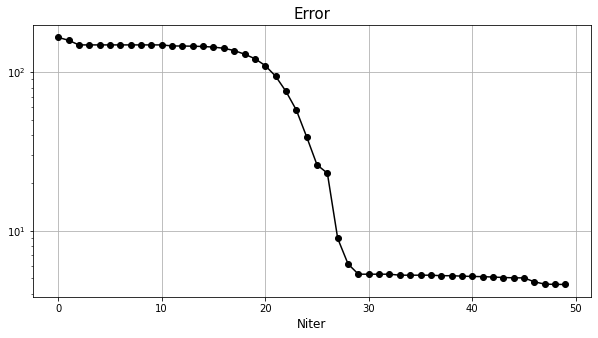

In [42]:
plt.figure(figsize=(10, 5))
plt.semilogy(fs, '-ok')
plt.title("Error", fontsize=15)
plt.xlabel("Niter", fontsize=12)
plt.grid()

In [43]:
call_calibrated = GetCalibratedData(call, heston_params, isCall=True)

put_calibrated = GetCalibratedData(put, heston_params, isCall=False)

## Plot results

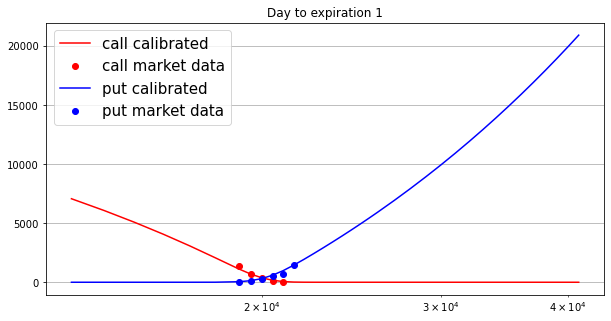

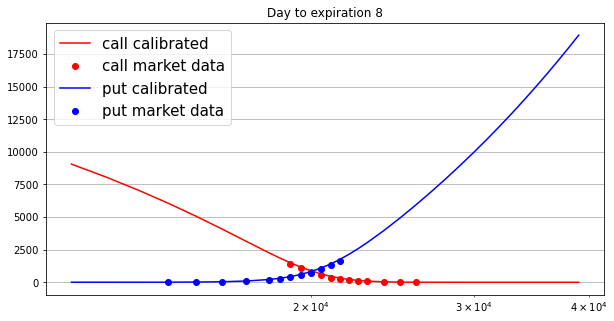

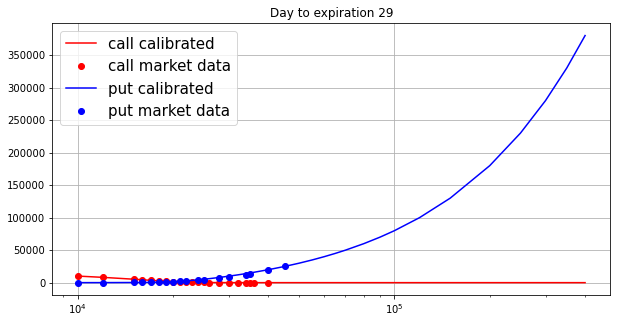

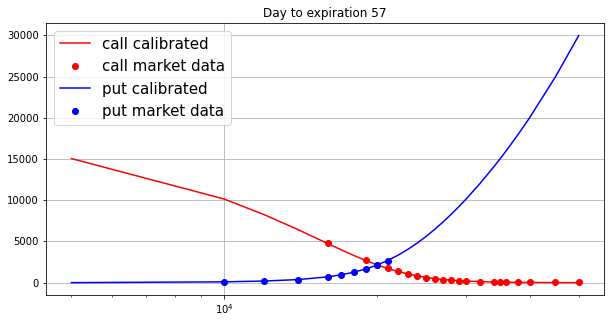

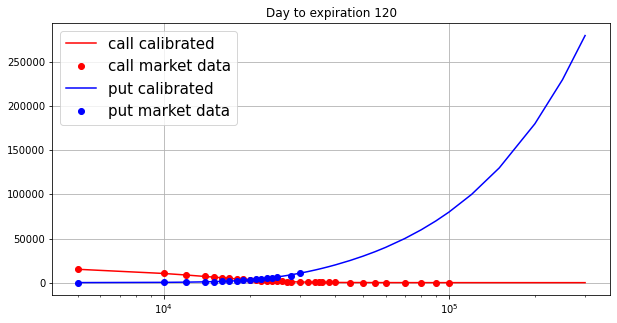

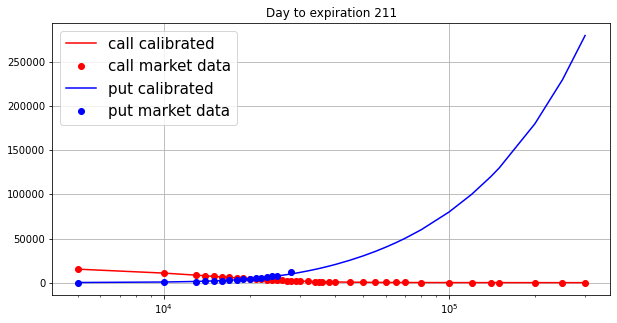

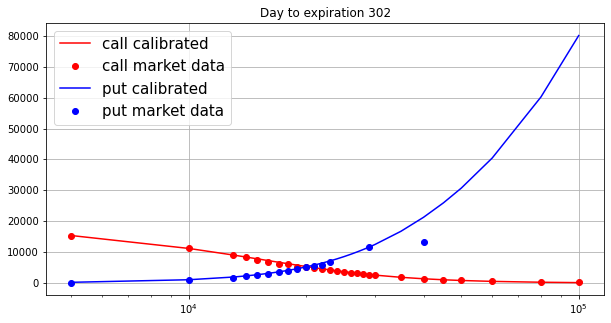

In [44]:
for (d, call_calib), (_, put_calib) in zip(call_calibrated.groupby('days'), put_calibrated.groupby('days')):
    
    call_tmp = call[call.days == d]
    put_tmp  = put[put.days == d]
    
    K = call_calib.strike_price
    C_calib = call_calib.mid_price + 1e-5
    C_mid = call_tmp.mid_price * call_tmp.underlying_price + 1e-5
    
    plt.figure(figsize=(10, 5))
    plt.semilogx(K, C_calib, '-r', label='call calibrated')
    plt.semilogx(K, C_mid,   'ro', label='call market data')
    
    K = put_calib.strike_price
    P_calib = put_calib.mid_price + 1e-5
    P_mid = put_tmp.mid_price * put_tmp.underlying_price + 1e-5

    plt.semilogx(K, P_calib, '-b', label='put calibrated')
    plt.semilogx(K, P_mid,   'bo', label='put market data')
    
    plt.legend(fontsize=15)
    plt.title(f'Day to expiration {d}')
    plt.grid()

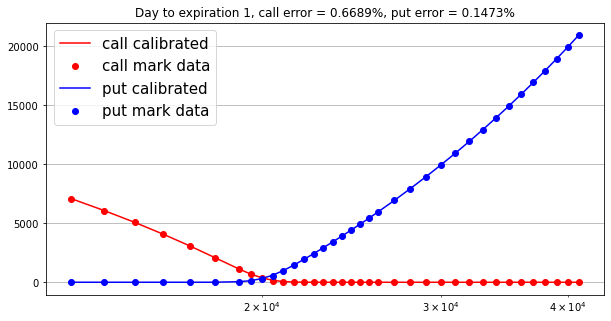

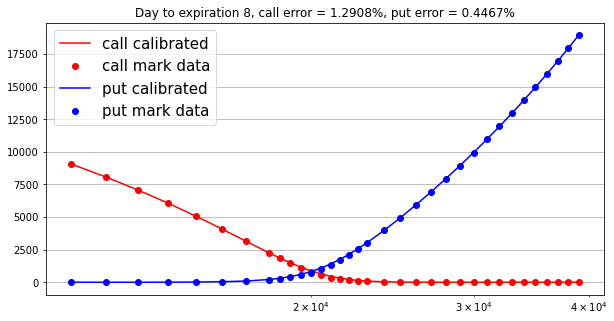

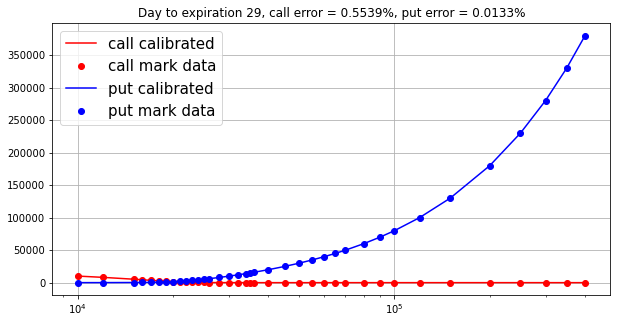

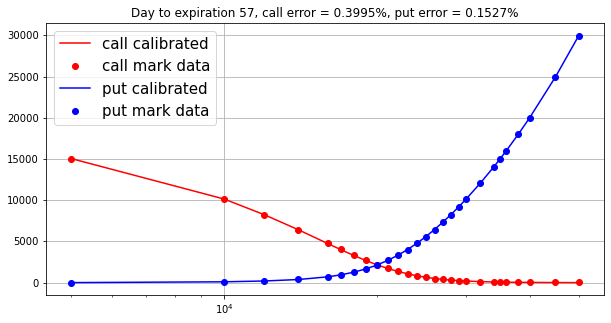

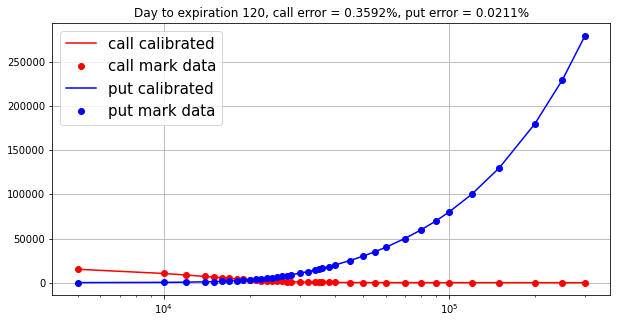

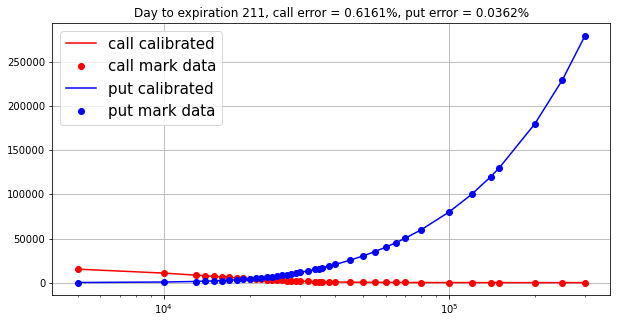

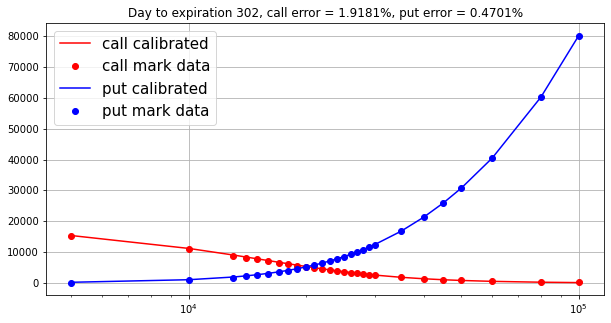

In [45]:
for (d, call_calib), (_, put_calib) in zip(call_calibrated.groupby('days'), put_calibrated.groupby('days')):
    
    call_tmp = call[call.days == d]
    put_tmp  = put[put.days == d]
    
    K = call_calib.strike_price
    C_calib = call_calib.mid_price + 1e-5
    C_mark = call_tmp.mark_price * call_tmp.underlying_price + 1e-5
    
    error_call = 100 * np.linalg.norm(C_mark - C_calib) / np.linalg.norm(C_mark)
    
    plt.figure(figsize=(10, 5))
    plt.semilogx(K, C_calib, '-r', label='call calibrated')
    plt.semilogx(K, C_mark,  'ro', label='call mark data')
    
    K = put_calib.strike_price
    P_calib = put_calib.mid_price + 1e-5
    P_mark = put_tmp.mark_price * put_tmp.underlying_price + 1e-5
    
    error_put = 100 * np.linalg.norm(P_mark - P_calib) / np.linalg.norm(P_mark)

    plt.semilogx(K, P_calib, '-b', label='put calibrated')
    plt.semilogx(K, P_mark,  'bo', label='put mark data')
    
    plt.legend(fontsize=15)
    plt.title(f'Day to expiration {d}, call error = {error_call:.4f}%, put error = {error_put:.4f}%')
    plt.grid()

7.186653082476447
4.565399787651333


/home/alex/study/vega/stochval/MathFinance/CryptoOptionsCalibration/../heston/heston_derivatives.py:33: RuntimeWarning: overflow encountered in multiply
  A2 = (d * c + xi * s)
/home/alex/study/vega/stochval/MathFinance/CryptoOptionsCalibration/../heston/heston_derivatives.py:36: RuntimeWarning: overflow encountered in exp
  B = d * np.exp(k * tau / 2) / A2
/home/alex/study/vega/stochval/MathFinance/CryptoOptionsCalibration/../heston/heston_derivatives.py:36: RuntimeWarning: invalid value encountered in true_divide
  B = d * np.exp(k * tau / 2) / A2
/home/alex/study/vega/stochval/MathFinance/CryptoOptionsCalibration/../heston/heston_derivatives.py:50: RuntimeWarning: overflow encountered in exp
  B_rho = np.exp(k * tau / 2) * (d_rho - d * A2_rho / A2) / A2
/home/alex/study/vega/stochval/MathFinance/CryptoOptionsCalibration/../heston/heston_derivatives.py:51: RuntimeWarning: invalid value encountered in true_divide
  A_rho = (A1_rho - A * A2_rho) / A2
/home/alex/study/vega/stochval/Math

3.640744125624315


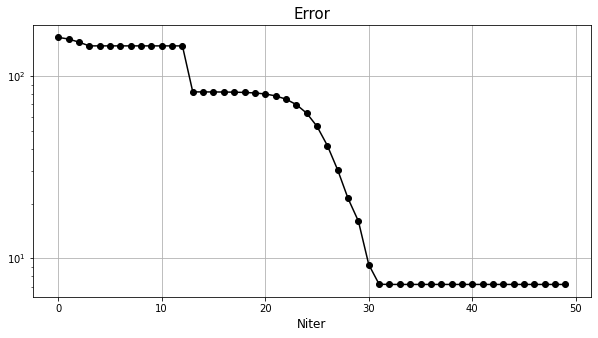

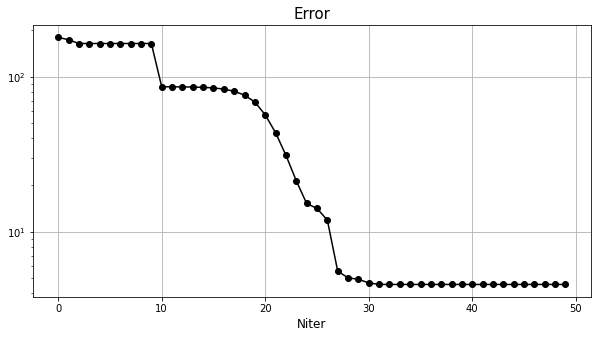

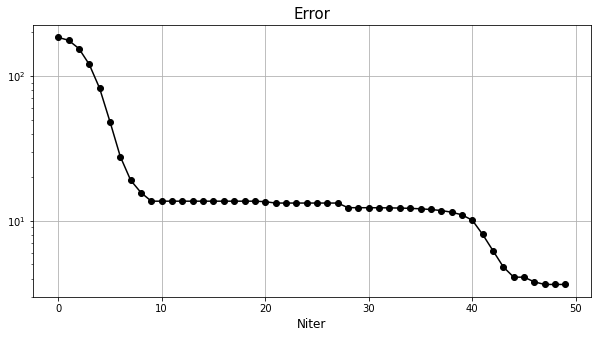

In [47]:
error_calls = []
error_puts = []

Ndims = [1, 2, 3]

ntry = 3

for Ndim in Ndims:
    
    fs_min = np.inf
    fs = None
    heston_params = None
    #
    for _ in range(ntry):
        heston_params_, fs_ = calibrate(put, call, Niter=50, Ndim=Ndim, heston_params=None)
        if fs_[-1] < fs_min:
            fs_min = fs_[-1]
            heston_params = heston_params_
            fs = fs_
            
    plt.figure(figsize=(10, 5))
    plt.semilogy(fs, '-ok')
    plt.title("Error", fontsize=15)
    plt.xlabel("Niter", fontsize=12)
    plt.grid()
    print(fs[-1])
    
    call_calibrated = GetCalibratedData(call, heston_params, isCall=True)

    put_calibrated = GetCalibratedData(put, heston_params, isCall=False)
    
    C_mark = call.mark_price * call.underlying_price + 1e-5
    C_calib = call_calibrated.mid_price

    P_mark = put.mark_price * put.underlying_price + 1e-5
    P_calib = put_calibrated.mid_price
    
    error_call = 100 * np.linalg.norm(C_mark - C_calib) / np.linalg.norm(C_mark)
    error_put = 100 * np.linalg.norm(P_mark - P_calib) / np.linalg.norm(P_mark)
    
    error_calls.append(error_call)
    error_puts.append(error_put) 

In [48]:
error_calls

[1.4324699161970966, 1.1218431011576868, 0.5483686306126714]

In [49]:
error_puts

[0.0875893454869853, 0.06879294227805675, 0.03540791041949914]